# Analysis of Otx-a SEL-seq data from Farley et al. (2015)
This dataset represents SEL-seq data generated by first constructing a dictionary of unique barcode tag-enhancer pairs by allowing 2 bp mismatches in the ~69 bp enhancers to buffer the sequencing mistakes. If more than one barcode tag was associated with a single enhancer the maximum reads between these tags were used. Barcoded tags that were attached to multiple enhancers were removed. The resulting dictionary contains 2,534,802 enhancers that are uniquely mapped to one or more barcode tags. 2 biological replicates were used in this experiment and the reads per million total reads (RPM) was used for each tag. In total 163,708 enhancers were detected by RNA-seq and 21,799 of them were defined as active enhancers by RPM ≥ 4 in either of the 2 replicates.

![farley15](images/farley15.jpeg)

In [1]:
# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload 
%autoreload 2

# Python imports for analysis
import numpy as np
import pandas as pd
import eugene as eu

# Configure EUGENe 
print(eu.__version__)
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/farley15"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/farley15"
eu.settings.dl_num_workers = 4
eu.settings.batch_size = 128 

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000
0.1.0


# Dataloading

In [2]:
# Load the dataset from the module
sdata = eu.datasets.farley15()
sdata

Dataset farley15 farley2015_seqs.csv has already been dowloaded.
Dataset farley15 farley2015_seqs_annot.csv has already been dowloaded.


SeqData object with = 163708 seqs
seqs = (163708,)
names = (163708,)
rev_seqs = None
ohe_seqs = None
ohe_rev_seqs = None
seqs_annot: 'Barcode', 'Biological Replicate 1 (RPM)', 'Biological Replicate 2 (RPM)'
pos_annot: None
seqsm: None
uns: None

# Data Visualization

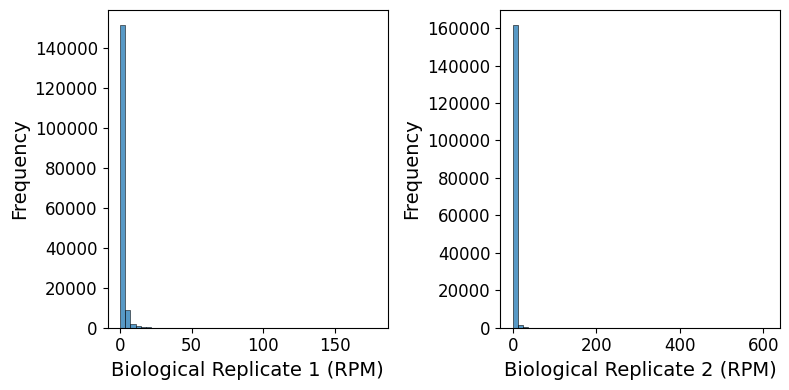

In [4]:
eu.pl.histplot(
    sdata, 
    keys=['Biological Replicate 1 (RPM)', 'Biological Replicate 2 (RPM)'],
    orient="h",
    bins=50
)

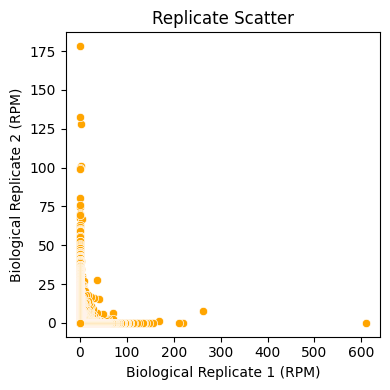

In [9]:
eu.pl.scatterplot(
    sdata, 
    x='Biological Replicate 1 (RPM)', 
    y='Biological Replicate 2 (RPM)',
    title="Replicate Scatter",
    color="orange"
)

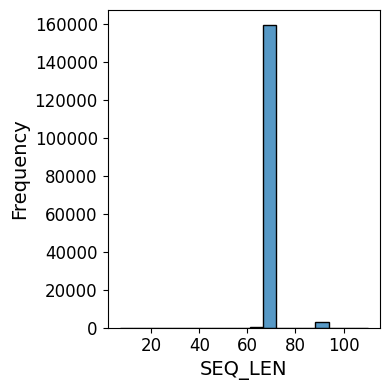

In [10]:
# Get and plot the distrubution on sequence length 
sdata["SEQ_LEN"] = [len(seq) for seq in sdata.seqs]
eu.pl.histplot(sdata, keys="SEQ_LEN", orient="h")

# Preprocessing

In [17]:
sdata_sub = sdata[sdata.seqs_annot[['Biological Replicate 1 (RPM)', 'Biological Replicate 2 (RPM)']].max(axis=1) >= 4]
sdata_sub

SeqData object with = 21799 seqs
seqs = (21799,)
names = (21799,)
rev_seqs = None
ohe_seqs = None
ohe_rev_seqs = None
seqs_annot: 'Barcode', 'Biological Replicate 1 (RPM)', 'Biological Replicate 2 (RPM)', 'SEQ_LEN'
pos_annot: None
seqsm: None
uns: None

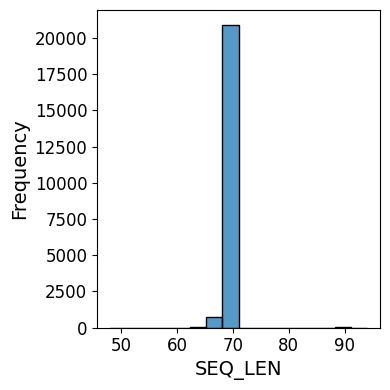

In [18]:
# Get and plot the distrubution on sequence length 
sdata_sub["SEQ_LEN"] = [len(seq) for seq in sdata_sub.seqs]
eu.pl.histplot(sdata_sub, keys="SEQ_LEN", orient="h")

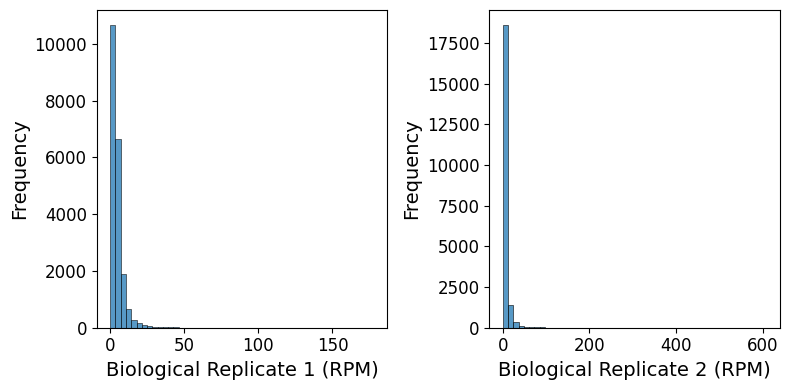

In [20]:
eu.pl.histplot(
    sdata_sub, 
    keys=['Biological Replicate 1 (RPM)', 'Biological Replicate 2 (RPM)'],
    orient="h",
    bins=50
)

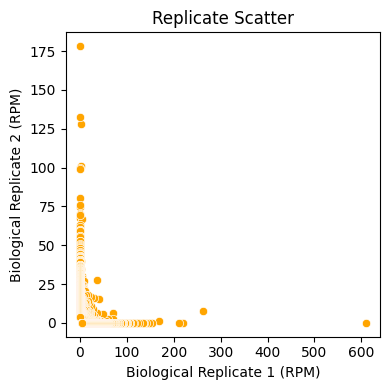

In [21]:
eu.pl.scatterplot(
    sdata_sub, 
    x='Biological Replicate 1 (RPM)', 
    y='Biological Replicate 2 (RPM)',
    title="Replicate Scatter",
    color="orange"
)

In [19]:
# Keep only the sequences with length = 69 and add reverse complement, ohe and training labels
sdata_sub = sdata_sub[sdata_sub["SEQ_LEN"] == 69]
eu.pp.prepare_data(sdata_sub)
sdata_sub

  0%|          | 0/3 [00:00<?, ?it/s]

SeqData object modified:
	rev_seqs: None -> 20585 rev_seqs added
	ohe_seqs: None -> 20585 ohe_seqs added
	ohe_rev_seqs: None -> 20585 ohe_rev_seqs added
    seqs_annot:
        + train


SeqData object with = 20585 seqs
seqs = (20585,)
names = (20585,)
rev_seqs = (20585,)
ohe_seqs = (20585, 69, 4)
ohe_rev_seqs = (20585, 69, 4)
seqs_annot: 'Barcode', 'Biological Replicate 1 (RPM)', 'Biological Replicate 2 (RPM)', 'SEQ_LEN', 'train'
pos_annot: None
seqsm: None
uns: None

In [42]:
sdata_sub[sdata_sub["train"] == True]["log(target)"].values.reshape(-1, 1)

array([[5.56832503],
       [5.12919959],
       [5.02836611],
       ...,
       [1.3886769 ],
       [1.3886769 ],
       [1.3886769 ]])

In [36]:
sdata_sub["train"].value_counts()

True     16468
False     4117
Name: train, dtype: int64

In [27]:
sdata_sub["target"] = sdata_sub.seqs_annot[['Biological Replicate 1 (RPM)', 'Biological Replicate 2 (RPM)']].max(axis=1)

In [43]:
# Create a scaled version of the normalized activity
sdata_sub["log(target)"] = np.log(sdata_sub["target"])
eu.pp.scale_targets(sdata_sub, target="log(target)", train_key="train")

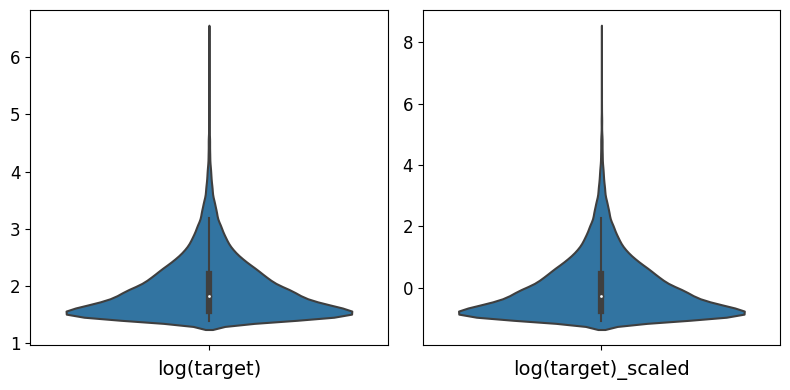

In [45]:
eu.pl.violinplot(
    sdata_sub, 
    keys=["log(target)", "log(target)_scaled"])

# Training

In [51]:
# Instantiate a simple CNN that 
model = eu.models.load_config(
    "CNN", 
    "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/configs/farley15/ssCNN_reg.yaml")
eu.models.base.init_weights(model)

In [52]:
model.summary()

Model: CNN
Input length: 69
Output dimension: 1
Strand: ss
Task: regression
Aggregation: None
Loss function: poisson_nll_loss
Optimizer: adam
Learning rate: 0.001
Scheduler: reduce_lr_on_plateau
Scheduler patience: 2


  | Name      | Type                      | Params
--------------------------------------------------------
0 | hp_metric | R2Score                   | 0     
1 | convnet   | BasicConv1D               | 12.4 K
2 | fcnet     | BasicFullyConnectedModule | 1.1 M 
--------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.584     Total estimated model params size (MB)

In [53]:
# Train the model for 100 epochs
eu.train.fit(
    model=model, 
    sdata=sdata_sub, 
    gpus=1, 
    target="log(target)",
    train_key="train",
    epochs=100,
    version="poisson_nll_v0"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type                      | Params
--------------------------------------------------------
0 | hp_metric | R2Score                   | 0     
1 | convnet   | BasicConv1D               | 12.4 K
2 | fcnet     | BasicFullyConnectedModule | 1.1 M 
--------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.584     Total estimated model params size (MB)


No transforms given, assuming just need to tensorize).
No transforms given, assuming just need to tensorize).


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 13


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.653


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.635


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.634


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.634


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.633


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.633


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.633


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.632


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.632. Signaling Trainer to stop.


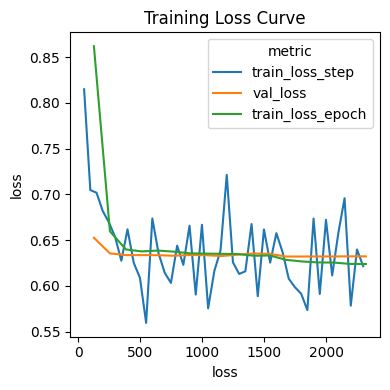

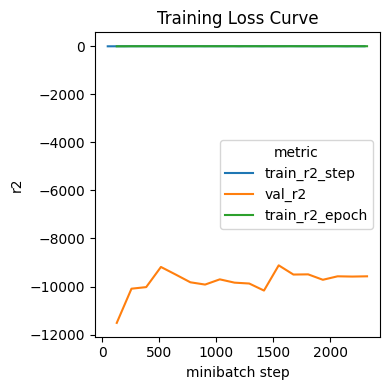

In [55]:
# Output training summary
eu.pl.training_summary(
    log_path=f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/farley15/ssCNN_regression/poisson_nll_v0/", 
    metrics="r2",
    title="Training Loss Curve",
)

In [56]:
# Load the best model from training
best_model = eu.models.CNN.load_from_checkpoint(f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/farley15/ssCNN_regression/poisson_nll_v0/checkpoints/epoch=12-step=1676.ckpt")

In [57]:
# Get train and validation predictions
eu.predict.train_val_predictions(
    best_model,
    sdata=sdata_sub,
    target="log(target)_scaled",
    train_key="train",
    version=f"ssCNN_poisson_nll_v0",
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + log(target)_scaled_predictions


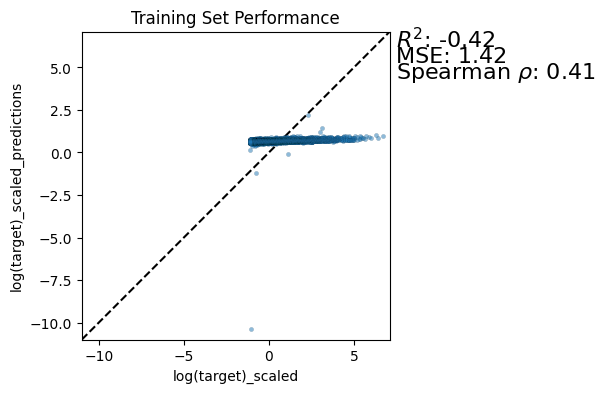

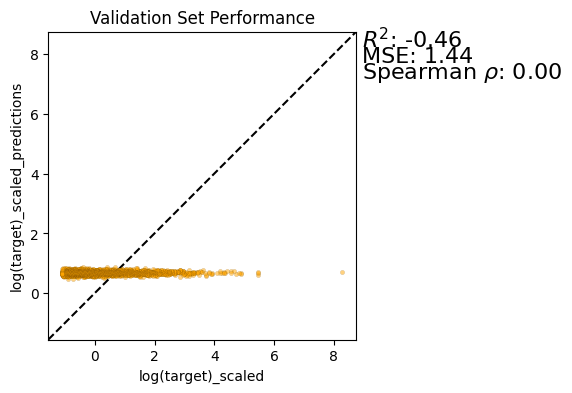

In [60]:
# Plot the performance scatterplot on the training and validation set
val_idx = np.where(sdata_sub["train"] == False)[0]
train_idx = np.where(sdata_sub["train"] == True)[0]
eu.pl.performance_scatter(
    sdata_sub, 
    seq_idx=train_idx, 
    target="log(target)_scaled", 
    prediction="log(target)_scaled_predictions",
    title="Training Set Performance",
    alpha=0.5,
)
eu.pl.performance_scatter(
    sdata_sub,
    seq_idx=val_idx,
    target="log(target)_scaled",
    prediction="log(target)_scaled_predictions",
    title="Validation Set Performance",
    color="orange",
    alpha=0.5,
)

In [62]:
import torch
from torchmetrics import R2Score
import sklearn.metrics

target = torch.tensor([3, -0.5, 2, 7])
preds = torch.tensor([2.5, 0.0, 2, 8])
tm_r2score = R2Score()
print(tm_r2score(preds, target))

y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print(sklearn.metrics.r2_score(y_true, y_pred))

sdata_train = sdata_sub[train_idx]
sdata_val = sdata_sub[val_idx]
uno = torch.tensor(sdata_train["log(target)_scaled"].values)
dos = torch.tensor(sdata_train["log(target)_scaled_predictions"].values)
print(tm_r2score(uno, dos))

uno_x, dos_x = uno.numpy(), dos.numpy()
print(sklearn.metrics.r2_score(uno_x, dos_x))

tensor(0.9486)
0.9486081370449679
tensor(-131.8895)
-0.42103867284654073


In [34]:
import torch
from torchmetrics import R2Score
import sklearn.metrics

target = torch.tensor([3, -0.5, 2, 7])
preds = torch.tensor([2.5, 0.0, 2, 8])
print(model.loss_fxn(preds, target))

y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print(sklearn.metrics.mean_squared_error(y_true, y_pred))

sdata_train = sdata_subset[train_idx]
uno = torch.tensor(sdata_train["log(max_activity)_SCALED"].values)
dos = torch.tensor(sdata_train["log(max_activity)_SCALED_PREDICTIONS"].values)
print(model.loss_fxn(uno, dos))

uno_x, dos_x = uno.numpy(), dos.numpy()
print(sklearn.metrics.mean_squared_error(uno_x, dos_x))

tensor(733.5074)
0.375
tensor(3.1943, dtype=torch.float64)
1.4080568562045297


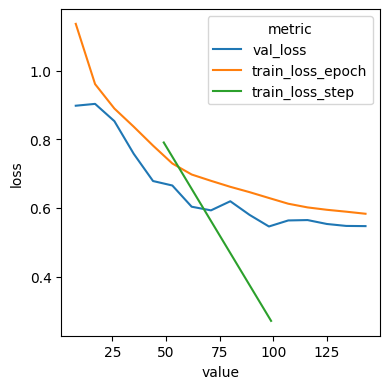

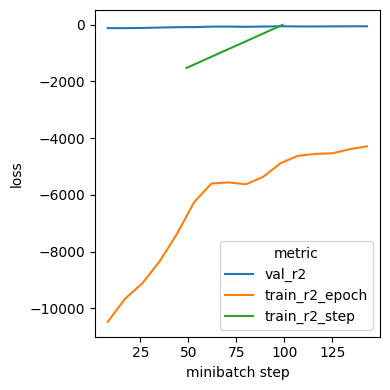

# Evaluation

In [31]:
# Get train and validation predictions
eu.predict.train_val_predictions(
    model, 
    sdata=sdata_subset, 
    target="log(max_activity)_SCALED",
    train_key="TRAIN",
    version="test0"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).
No transforms given, assuming just need to tensorize).


/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + log(max_activity)_SCALED_PREDICTIONS


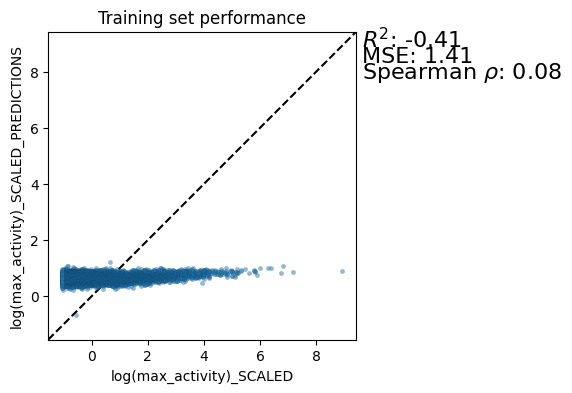

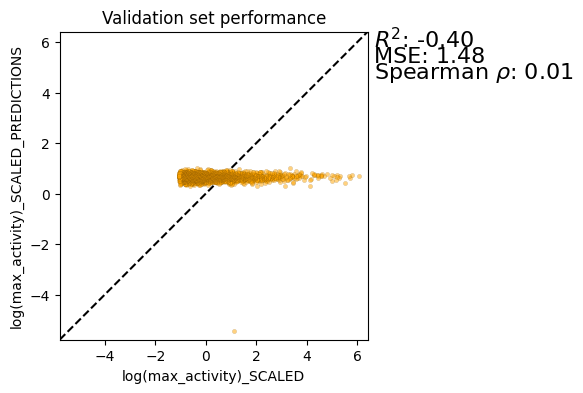

In [32]:
# Plot the performance scatterplot on the training and validation set
val_idx = np.where(sdata_subset["TRAIN"] == False)[0]
train_idx = np.where(sdata_subset["TRAIN"] == True)[0]
eu.pl.performance_scatter(
    sdata_subset, 
    seq_idx=train_idx, 
    target="log(max_activity)_SCALED", 
    prediction="log(max_activity)_SCALED_PREDICTIONS",
    title="Training set performance",
    alpha=0.5
)
eu.pl.performance_scatter(
    sdata_subset, 
    seq_idx=val_idx, 
    target="log(max_activity)_SCALED", 
    prediction="log(max_activity)_SCALED_PREDICTIONS",
    title="Validation set performance",
    color="orange",
    alpha=0.5
)

# Interpret 

In [134]:
eu.interpret.feature_attribution(model, sdata_subset)

No transforms given, assuming just need to tensorize).


Computing saliency on batches:   0%|          | 0/4 [00:00<?, ?it/s]

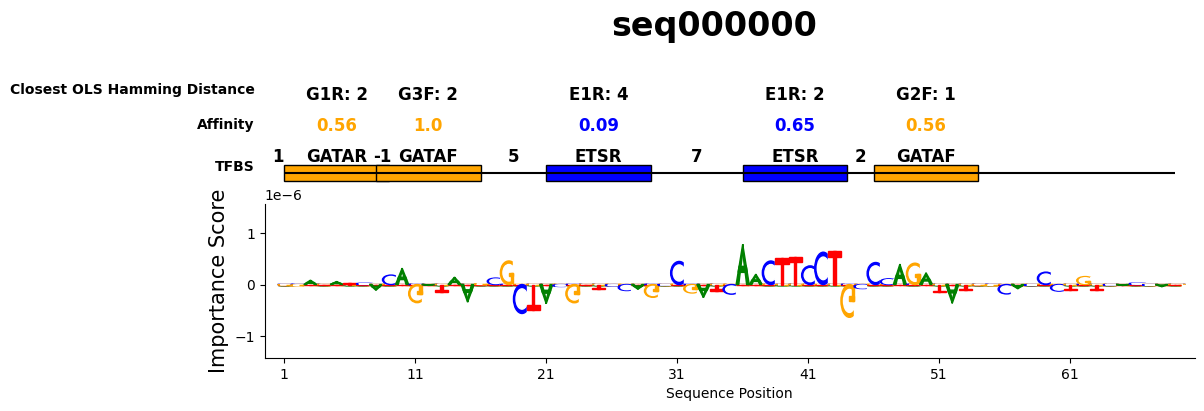

In [138]:
eu.pl.otx_seq(sdata_subset, seq_id=sdata_subset.names[0], uns_key="InputXGradient_imps")

In [149]:
eu.interpret.generate_pfms(model, sdata_subset)

No transforms given, assuming just need to tensorize).


Getting maximial activating seqlets:   0%|          | 0/4 [00:00<?, ?it/s]

Getting PFMs from filters:   0%|          | 0/32 [00:00<?, ?it/s]

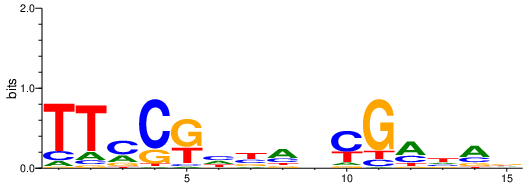

In [153]:
eu.pl.filter_viz(sdata_subset, filter_id=0)

---

# Scratch

In [ ]:
import torch
from torchmetrics import R2Score
import sklearn.metrics

target = torch.tensor([3, -0.5, 2, 7])
preds = torch.tensor([2.5, 0.0, 2, 8])
tm_r2score = R2Score()
print(tm_r2score(preds, target))

y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print(sklearn.metrics.r2_score(y_true, y_pred))

sdata_train = sdata_subset[train_idx]
sdata_val = sdata_subset[val_idx]
uno = torch.tensor(sdata_train["log(max_activity)_SCALED"].values)
dos = torch.tensor(sdata_train["log(max_activity)_SCALED_PREDICTIONS"].values)
print(tm_r2score(uno, dos))

uno_x, dos_x = uno.numpy(), dos.numpy()
print(sklearn.metrics.r2_score(uno_x, dos_x))

tensor(0.9486)
0.9486081370449679
tensor(-17.8863)
0.16492233358169228


In [ ]:
import torch
from torchmetrics import R2Score
import sklearn.metrics

target = torch.tensor([3, -0.5, 2, 7])
preds = torch.tensor([2.5, 0.0, 2, 8])
print(model.loss_fxn(preds, target))

y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print(sklearn.metrics.mean_squared_error(y_true, y_pred))

sdata_train = sdata_subset[train_idx]
uno = torch.tensor(sdata_train["log(max_activity)_SCALED"].values)
dos = torch.tensor(sdata_train["log(max_activity)_SCALED_PREDICTIONS"].values)
print(model.loss_fxn(uno, dos))

uno_x, dos_x = uno.numpy(), dos.numpy()
print(sklearn.metrics.mean_squared_error(uno_x, dos_x))

tensor(0.3750)
0.375
tensor(0.8351, dtype=torch.float64)
0.8350776664183077
